In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle

In [2]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

#### Drifter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2023_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['ID'][:].data
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
tim_drif = [datetime.fromisoformat(s) for s in dt_strings]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters

,ID,Lon,Lat,u,v,Time
0,1,155.071686,-37.423271,0.336407,-0.524240,2023-10-23 16:00:00
1,1,155.085403,-37.440243,0.342941,-0.514329,2023-10-23 17:00:00
2,1,155.099655,-37.456573,0.356158,-0.494175,2023-10-23 18:00:00
3,1,155.114456,-37.472240,0.367879,-0.471484,2023-10-23 19:00:00
4,1,155.129669,-37.487103,0.357340,-0.426944,2023-10-23 20:00:00
...,...,...,...,...,...,...
32704,19,157.954788,-33.808270,0.788511,-0.257061,2023-12-30 18:00:00
32705,19,157.985443,-33.815174,0.778468,-0.190267,2023-12-30 19:00:00
32706,19,158.015457,-33.820591,0.769020,-0.143037,2023-12-30 20:00:00
32707,19,158.045380,-33.824436,0.766826,-0.095277,2023-12-30 21:00:00


#### Ship Data

In [4]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=z_sadcp)
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=z_sadcp)
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

depth = 37
df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'u': u_sadcp.loc[depth], 'v': v_sadcp.loc[depth], 'Time': tim_sadcp})
df_sadcp

,Lon,Lat,u,v,Time
0,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...
2169,152.133657,-33.499170,-0.193570,-1.186649,2023-11-01 03:40:29.666685
2170,152.162703,-33.499744,-0.265587,-1.283703,2023-11-01 03:55:29.333340
2171,152.191377,-33.499695,-0.273816,-1.294686,2023-11-01 04:10:29.666658
2172,152.220223,-33.499658,-0.283102,-1.272112,2023-11-01 04:25:29.333353


,ID,Lon,Lat,u,v,Time
0,NaN,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,NaN,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,NaN,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,NaN,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,NaN,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...,...
34878,8.0,163.780426,-29.946438,0.223790,-0.060704,2023-12-30 23:00:00.000000
34879,4.0,162.917786,-38.022373,0.095789,0.021097,2023-12-30 23:00:00.000000
34880,6.0,163.140686,-29.742563,0.579057,-0.107962,2023-12-30 23:00:00.000000
34881,7.0,164.334869,-33.275684,0.171763,-0.353148,2023-12-30 23:00:00.000000


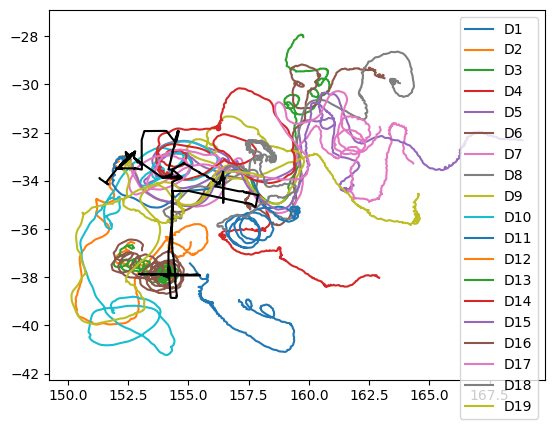

In [5]:
for ID in df_drifters['ID'].unique():
    df_drif = df_drifters[df_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
plt.axis('equal')
plt.legend()
plt.plot(df_sadcp['Lon'], df_sadcp['Lat'], c='k')

df_obs_data = pd.concat([df_drifters, df_sadcp], ignore_index=True, sort=False)
df_obs_data = df_obs_data.sort_values(by='Time').reset_index(drop=True)
df_obs_data

#### Satellite Data

In [6]:
ssh_path = '/srv/scratch/z5297792/IN2023/IMOS_aggregation.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')
lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
# u_ssh, v_ssh = np.where(u_ssh > -4, u_ssh, np.nan), np.where(v_ssh > -4, u_ssh, np.nan)
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

tim_ssh = tim_ssh[tim_ssh <= pd.Timestamp('2023-12-05 06:00:00')] # '2023-12-11 14:00:00'


(np.float64(154.53241883608766), np.float64(-37.9629414382285))

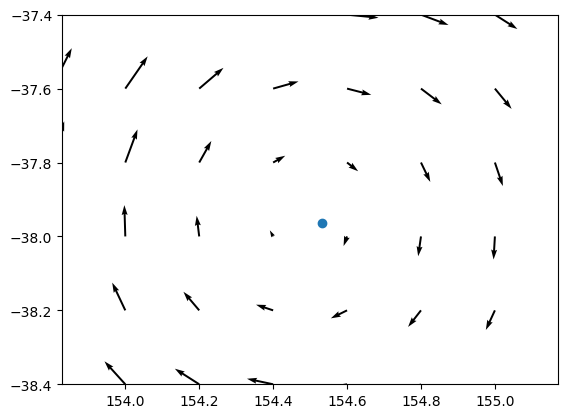

In [7]:
lon_min_CE, lon_max_CE = 154, 155
lat_min_CE, lat_max_CE = -38.4, -37.4

t = 0
ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
plt.quiver(lon_ssh, lat_ssh, ut.T, vt.T, width=.004, scale=10)

mask = (lon_ssh >= lon_min_CE) & (lon_ssh <= lon_max_CE) & (lat_ssh >= lat_min_CE) & (lat_ssh <= lat_max_CE)
xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
x0_ssh_start, y0_ssh_start, *_ = espra(xi, yi, ui, vi)
plt.scatter(x0_ssh_start, y0_ssh_start)

plt.axis('equal')
plt.xlim(lon_min_CE, lon_max_CE)
plt.ylim(lat_min_CE, lat_max_CE)
(x0_ssh_start, y0_ssh_start)

,x0,y0,Q,w,Time
0,154.480060,-37.954790,"[[-0.7831447789114259, 0.02670275721933442], [...",-3.054847,2023-10-09 18:00:00
1,154.467519,-37.931639,"[[-0.7070433515299916, 0.06208487690070891], [...",-2.906459,2023-10-10 18:00:00
2,154.448446,-37.909527,"[[-0.806986895158862, 0.09231684644359126], [0...",-3.113594,2023-10-11 18:00:00
3,154.455736,-37.891271,"[[-0.7593039067853671, 0.08077726314573079], [...",-2.972068,2023-10-12 18:00:00
4,154.464998,-37.877260,"[[-0.761974154137779, 0.055981465302784174], [...",-2.911793,2023-10-13 18:00:00


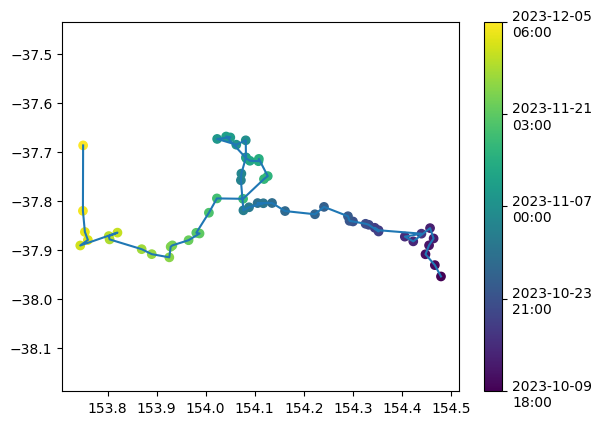

In [8]:
df_ssh_trace = pd.DataFrame(columns=['x0', 'y0', 'Q', 'w', 'Time'])
x0, y0 = (np.float64(154.53241883608766), np.float64(-37.9629414382285)) #start
for t, time in enumerate(tim_ssh):
    mask = np.hypot(x0 - lon_ssh, y0 - lat_ssh) <= .2
    ut, vt = u_ssh[:,:,t], v_ssh[:,:,t]
    xi, yi, ui, vi = lon_ssh[mask], lat_ssh[mask], ut.T[mask], vt.T[mask]
    x0, y0, Q, w = espra(xi, yi, ui, vi)
    df_ssh_trace.loc[len(df_ssh_trace)] = {'x0': x0, 'y0': y0, 'Q': Q, 'w': w, 'Time': time}
# df_ssh_trace = df_ssh_trace.set_index('Time')
plt.plot(df_ssh_trace['x0'], df_ssh_trace['y0'])
times = df_ssh_trace['Time']
norm = plt.Normalize(times.min().timestamp(), times.max().timestamp())
sc = plt.scatter(df_ssh_trace['x0'], df_ssh_trace['y0'], c=times.apply(lambda x: x.timestamp()), cmap='viridis', norm=norm)
cbar = plt.colorbar(sc)
ticks = np.linspace(times.min().timestamp(), times.max().timestamp(), 5)
cbar.set_ticks(ticks)
cbar.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
plt.axis('equal')
df_ssh_trace.head()


In [9]:
dic_obs = {}
df_obs_trace = pd.DataFrame(columns=['x0_obs', 'y0_obs', 'Q_obs', 'w_obs', 'Time'])
for k in range(len(df_ssh_trace)):
    df = df_ssh_trace.iloc[k]
    x0_sat, y0_sat, Q_sat, time_sat = df['x0'], df['y0'], df['Q'], df['Time']

    R = np.hypot(df_obs_data['Lon'] - x0_sat, df_obs_data['Lat'] - y0_sat) < 1
    t1 = time_sat - pd.Timedelta(days=.75)
    t2 = time_sat + pd.Timedelta(days=.75)

    local_obs_data = df_obs_data[(R) & (df_obs_data['Time'] >= t1) & (df_obs_data['Time'] <= t2)]
    if not local_obs_data.empty:
        xi, yi = local_obs_data['Lon'], local_obs_data['Lat']
        ui, vi = local_obs_data['u'], local_obs_data['v']
        time, ID = local_obs_data['Time'], local_obs_data['ID']
        dic_obs[time_sat] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi, 'ID': ID, 'Time': time}

        x0_obs, y0_obs, Q_obs, w_obs = espra(xi, yi, ui, vi)
        
        df_obs_trace.loc[len(df_obs_trace)] = {'x0_obs': x0_obs, 'y0_obs': y0_obs, 'Q_obs': Q_obs, 'w_obs': w_obs, 'Time': time_sat}
              
df_obs_trace.head()

,x0_obs,y0_obs,Q_obs,w_obs,Time
0,111.955678,447.829063,"[[7.828878015880974, 0.6847448624609698], [0.6...",15.778417,2023-10-16 18:00:00
1,154.412961,-37.755210,"[[-4.689529088941388, -0.3467095197813928], [-...",-10.214612,2023-10-17 18:00:00
2,154.323472,-37.876291,"[[-0.8706748013882835, -0.08339699349177361], ...",-2.403494,2023-10-18 18:00:00
3,154.504002,-37.918614,"[[-0.37625361500827115, 0.014126564331876673],...",-2.628438,2023-10-19 18:00:00
4,154.282134,-37.900568,"[[-0.4177115104058206, 0.08815260648052936], [...",-3.934003,2023-10-20 18:00:00


In [10]:
df_trace = pd.merge(df_ssh_trace, df_obs_trace, on='Time', how='outer')
df_trace = df_trace.dropna()
df_trace = df_trace[np.sign(df_trace['w']) == np.sign(df_trace['w_obs'])]
df_trace = df_trace[np.hypot(df_trace['x0'] - df_trace['x0_obs'], df_trace['y0'] - df_trace['y0_obs']) < .5]
df_trace.head()

,x0,y0,Q,w,Time,x0_obs,y0_obs,Q_obs,w_obs
9,154.352720,-37.860513,"[[-0.8606782183142047, 0.012017357177674153], ...",-3.227273,2023-10-18 18:00:00,154.323472,-37.876291,"[[-0.8706748013882835, -0.08339699349177361], ...",-2.403494
10,154.344859,-37.855427,"[[-0.8999421051691384, -0.02708567265873329], ...",-3.273945,2023-10-19 18:00:00,154.504002,-37.918614,"[[-0.37625361500827115, 0.014126564331876673],...",-2.628438
11,154.352718,-37.863061,"[[-0.9821539909092948, -0.05798630092538625], ...",-3.569981,2023-10-20 18:00:00,154.282134,-37.900568,"[[-0.4177115104058206, 0.08815260648052936], [...",-3.934003
12,154.332693,-37.849408,"[[-0.9382820873102853, -0.018311369836641465],...",-3.431118,2023-10-21 18:00:00,154.295576,-37.815594,"[[-0.4294895419946137, 0.057610223318970546], ...",-1.421153
13,154.326224,-37.847343,"[[-0.8898326059069167, -0.03891186142143193], ...",-3.258685,2023-10-22 18:00:00,154.166105,-37.804740,"[[-1.507726514979478, 0.012895005101047276], [...",-3.569453


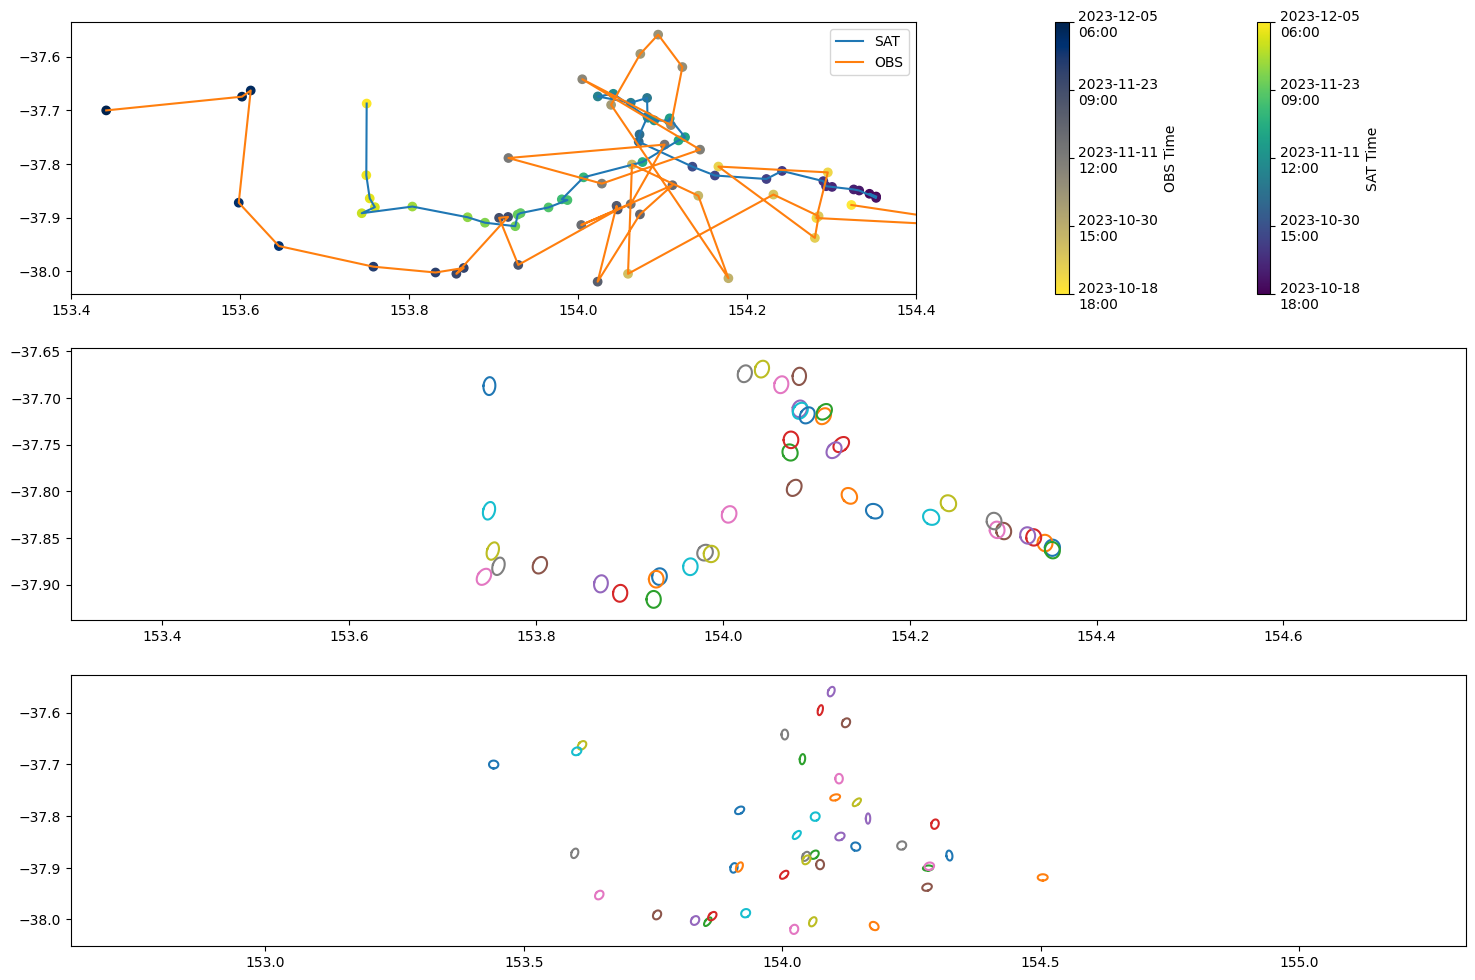

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

# Plot SAT path
axs[0].plot(df_trace['x0'], df_trace['y0'], label='SAT')
for x0, y0, Q in zip(df_trace['x0'], df_trace['y0'], df_trace['Q']):
    x_ell, y_ell = plot_ellipse(Q, (x0, y0), scale=0.01)
    axs[1].plot(x_ell, y_ell)

# axs[1].set_xlim(153.4, 154.4)
axs[1].axis('equal')

# Plot OBS path
axs[0].plot(df_trace['x0_obs'], df_trace['y0_obs'], label='OBS')
for x0, y0, Q in zip(df_trace['x0_obs'], df_trace['y0_obs'], df_trace['Q_obs']):
    x_ell, y_ell = plot_ellipse(Q, (x0, y0), scale=0.01)
    axs[2].plot(x_ell, y_ell)

# axs[2].set_xlim(153.4, 154.4)
axs[2].axis('equal')

# Time values
times = df_trace['Time']
timestamps = times.apply(lambda x: x.timestamp())

# SAT scatter + colorbar
norm_sat = plt.Normalize(timestamps.min(), timestamps.max())
sc1 = axs[0].scatter(df_trace['x0'], df_trace['y0'], c=timestamps, cmap='viridis', norm=norm_sat)
cbar1 = fig.colorbar(sc1, ax=axs[0], location='right', pad=0.02)
ticks = np.linspace(timestamps.min(), timestamps.max(), 5)
cbar1.set_ticks(ticks)
cbar1.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar1.set_label('SAT Time')

# OBS scatter + separate colorbar
sc2 = axs[0].scatter(df_trace['x0_obs'], df_trace['y0_obs'], c=timestamps, cmap='cividis_r', norm=norm_sat)
cbar2 = fig.colorbar(sc2, ax=axs[0], location='right', pad=0.12)
cbar2.set_ticks(ticks)
cbar2.set_ticklabels(pd.to_datetime(ticks, unit='s').strftime('%Y-%m-%d\n%H:%M'))
cbar2.set_label('OBS Time')

axs[0].set_xlim(153.4, 154.4)
axs[0].legend()


